# Credit Risk Classifications

by: <a href="http://keithqu.com">Keith Qu</a>

Using the data set from Kaggle's <a href="https://www.kaggle.com/c/GiveMeSomeCredit/">Give Me Some Credit</a> competition, which contains 150,000 observations with 10 features and the objective of predicting whether a lendee will have a serious delinquincy (90+ days past due) within 2 years.

Contents:

<ul>
<li><a href="#ecc">Exploration, Cleaning, Creating Features</a></li>
<li><a href="#visual">Visualizing n-Dimensional Data</a></li>
<li><a href="#model">Building the Model</a></li>
<li><a href="#age">Assessing Age as a Feature</a></li>
<li><a href="#conc">Conclusion</a></li>
</ul>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.stats import randint, uniform
from scipy import linalg
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
import random
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


<a id='ecc'></a>
## Exploration, Cleaning, Creating Features

We have the following variables:

<ul>
<li><b><u>SeriousDlqin2yrs</u></b> (target): individual experiences a 90+ day overdue payment within 2 years</li>
<li><b>age</b></li>
<li><b>RevolvingUtilizationOfUnsecuredLines</b>: balance on credit cards and lines of credit / sum of limits (excluding real etate,  installment debt)</li>
<li><b>DebtRatio</b>: monthly debt, alimony, living cost payments divided by monthly income</li>
<li><b>NumberRealEstateLoansOrLines</b>: only real estate loans</li>
<li><b>NumberOfOpenCreditLinesAndLoans</b>: # install ment loans and LOCs</li>
<li><b>NumberOfTime30-59DaysPastDueNotWorse</b>: number of times person experienced 30-59 day lateness, but not more than that</li>
<li><b>NumberOfTime60-89DaysPastDueNotWorse</b>: same as above with 60-89 days</li>
<li><b>NumberOfTime90DaysPastDueNotWorse</b>: same as above with 90+</li>
<li><b>NumberOfDependents</b>: number of family members excluding self</li>
<li><b>MonthlyIncome</b></li>

In [2]:
df = pd.read_csv('cs-training.csv',index_col=0)
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


### Balance
Only 6.684% of the observations have delinquincies.

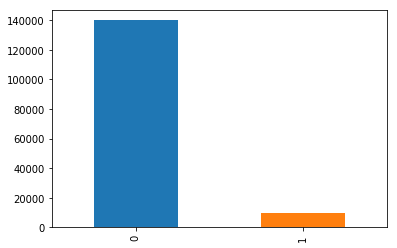

In [4]:
df['SeriousDlqin2yrs'].value_counts().plot(kind='bar')

In [5]:
df['SeriousDlqin2yrs'].mean()

0.06684

### Serious delinquincies

In [6]:
df['SeriousDlqin2yrs'].describe()

count    150000.000000
mean          0.066840
std           0.249746
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: SeriousDlqin2yrs, dtype: float64

Nothing odd here.

### Age
There's someone aged 0, which should be an error. Let's set it to 21, the minimum age that makes sense. This won't make a huge difference considering there are 150,000 observations.

In [7]:
df['age'].value_counts().sort_index().iloc[:20]

0        1
21     183
22     434
23     641
24     816
25     953
26    1193
27    1338
28    1560
29    1702
30    1937
31    2038
32    2050
33    2239
34    2155
35    2246
36    2379
37    2521
38    2631
39    2987
Name: age, dtype: int64

In [8]:
df['age'].value_counts().sort_index().iloc[-10:]

96     18
97     17
98      6
99      9
101     3
102     3
103     3
105     1
107     1
109     2
Name: age, dtype: int64

In [9]:
df.loc[df['age']==0,'age'] = 21

### Revolving Utilization Of Unsecured Lines

This should be a ratio but for many observations they seem to actually be dollar amounts.

In [10]:
df['RevolvingUtilizationOfUnsecuredLines'].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [11]:
df['RevolvingUtilizationOfUnsecuredLines'].median()

0.154180737

Text(0.5,1,'Revolving Utilization by Percentile')

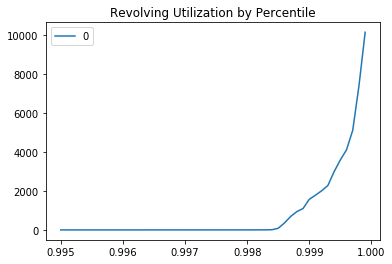

In [12]:
freq=pd.DataFrame(sorted(df['RevolvingUtilizationOfUnsecuredLines']))
freq.quantile(q=np.arange(0.995,0.99999,0.0001)).plot()
plt.title('Revolving Utilization by Percentile')

The values are "normal" until some point after the 99.8th percentile, so there fewer than 300 "irregular" values.

In [13]:
freq.quantile(q=[0.998])

,0
0.998,2.761009


In [313]:
df[df['MonthlyIncome']>=2.761009].head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyPayments,logMI,logMP
1,1,0.766127,45,2.0,0.802982,9120.0,13,0.0,6.0,0.0,2.0,7323.197016,9.118225,8.898802
2,0,0.957151,40,0.0,0.121876,2600.0,4,0.0,0.0,0.0,1.0,316.878123,7.863267,5.758517
3,0,0.658180,38,1.0,0.085113,3042.0,2,1.0,0.0,0.0,0.0,258.914887,8.020270,5.556499
4,0,0.233810,30,0.0,0.036050,3300.0,5,0.0,0.0,0.0,0.0,118.963951,8.101678,4.778821
5,0,0.907239,49,1.0,0.024926,63588.0,7,0.0,1.0,0.0,0.0,1584.975094,11.060180,7.368324


With a media of 0.154 and mean of 6.04 there is huge positive skewness. It's possible that there is some inconsistency in the data. Even accounts that are victims of fraud will not have rates in the thousands.  It is possible that they were recorded as dollar amounts, or when credit card limits were unavailable, 1 was substituted in the denominators.

Regardless, we should deal with this problem in some way, such as censoring all amounts above some threshold. We will play it safe and use 2.5.

In [15]:
df['RevolvingUtilizationOfUnsecuredLines'] = df['RevolvingUtilizationOfUnsecuredLines'].apply(lambda i:i if i <= 2.5 else 2.5)

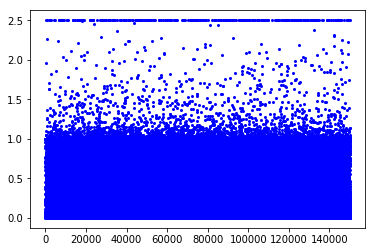

In [16]:
plt.plot(df['RevolvingUtilizationOfUnsecuredLines'], 'bo', markersize=2)

### Lateness

<ul>
<li>NumberOfTime30-59DaysPastDueNotWorse</li>
<li>NumberOfTime60-89DaysPastDueNotWorse</li>
<li>NumberOfTimes90DaysLate</li>
</ul>

There are some outliers in these values. While it may be feasible, if unlikely, for someone to have nearly 100 loans past due, in the actual data, these people with huge numbers of defaults don't seem more likely to default than anyone else.

In [17]:
df['NumberOfTime30-59DaysPastDueNotWorse'].value_counts().sort_index()

0     126018
1      16033
2       4598
3       1754
4        747
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
96         5
98       264
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

In [18]:
df['NumberOfTime30-59DaysPastDueNotWorse'] = [v if v <= 13 else np.median(df['NumberOfTime30-59DaysPastDueNotWorse'])
                                              for v in df['NumberOfTime30-59DaysPastDueNotWorse']]

In [19]:
df['NumberOfTime60-89DaysPastDueNotWorse'].value_counts().sort_index()

0     142396
1       5731
2       1118
3        318
4        105
5         34
6         16
7          9
8          2
9          1
11         1
96         5
98       264
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

In [20]:
df['NumberOfTime60-89DaysPastDueNotWorse'] = [v if v <= 11 else np.median(df['NumberOfTime60-89DaysPastDueNotWorse'])
                                              for v in df['NumberOfTime60-89DaysPastDueNotWorse']]

In [21]:
df['NumberOfTimes90DaysLate'].value_counts().sort_index()

0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

In [22]:
df['NumberOfTimes90DaysLate'] = [v if v <= 17 else np.median(df['NumberOfTimes90DaysLate'])
                                              for v in df['NumberOfTimes90DaysLate']]

In [23]:
latecor = df[['SeriousDlqin2yrs','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate']].copy()

In [24]:
for c in latecor.columns:
    latecor[c] = [v if v < 1 else 1 for v in latecor[c]]

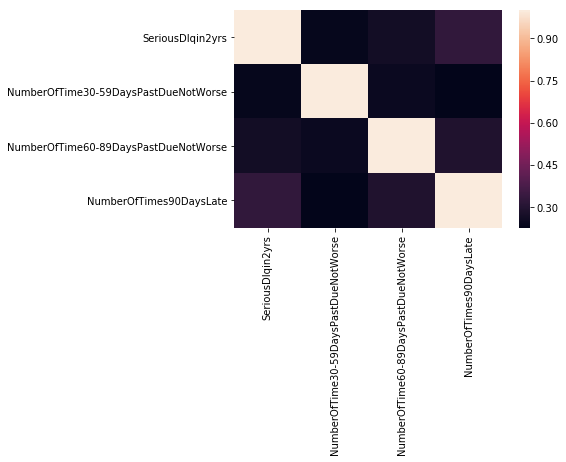

In [25]:
sns.heatmap(latecor.corr())

In [26]:
latecor.corr()

,SeriousDlqin2yrs,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
SeriousDlqin2yrs,1.000000,0.238023,0.263986,0.329598
NumberOfTime30-59DaysPastDueNotWorse,0.238023,1.000000,0.251190,0.227149
NumberOfTime60-89DaysPastDueNotWorse,0.263986,0.251190,1.000000,0.291774
NumberOfTimes90DaysLate,0.329598,0.227149,0.291774,1.000000


We can see that the correlation between delinquincy within 2 years increases in the number of days of lateness.

### Number of dependents

There is no reason to suspect any of these numbers, even the 2 outliers within 13 and 20 dependents. Those numbers are not out of the question at all. We can set the 2 outliers to 10, but we'll leave them be for now.

There is missing data we will fill with the median, which turns out to just be 0.

In [27]:
df['NumberOfDependents'].value_counts().sort_index()

0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

In [28]:
df['NumberOfDependents'].median()

0.0

In [29]:
df['NumberOfDependents'].fillna(0, inplace=True)

### Real estate loans

Like unsecured credit utilization, there are a small number of outliers that we can choose to censor. Let's set 15 as a threshold. These higher numbers of real estate loans don't necessarily give us that much relevant information.

In [30]:
df['NumberRealEstateLoansOrLines'].value_counts().sort_index()

0     56188
1     52338
2     31522
3      6300
4      2170
5       689
6       320
7       171
8        93
9        78
10       37
11       23
12       18
13       15
14        7
15        7
16        4
17        4
18        2
19        2
20        2
21        1
23        2
25        3
26        1
29        1
32        1
54        1
Name: NumberRealEstateLoansOrLines, dtype: int64

In [31]:
df['NumberRealEstateLoansOrLines'] = [v if v <= 15 else np.median(df['NumberRealEstateLoansOrLines'])
                                              for v in df['NumberRealEstateLoansOrLines']]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null float64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null float64
NumberRealEstateLoansOrLines            150000 non-null float64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null float64
NumberOfDependents                      150000 non-null float64
dtypes: float64(8), int64(3)
memory usage: 13.7 MB


### Debt Ratio

As with revolving utilization, the ratio is not too informative when the denominator is very low. 329664 doesn't make much since as a debt ratio, but it makes a lot of sense for a dollar amount. Indeed, the documentation describes DebtRatio as debt payments, alimony and living costs divided by monthly gross income. We can surmise that when income was 0 or was missing, 1 was substituted.

In [33]:
df['DebtRatio'].describe()

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

In [34]:
df[df['MonthlyIncome'].isnull()].describe()['DebtRatio']

count     29731.000000
mean       1673.396556
std        4248.372895
min           0.000000
25%         123.000000
50%        1159.000000
75%        2382.000000
max      329664.000000
Name: DebtRatio, dtype: float64

This actually gives us an interesting opportunity to create a monthly payments feature. But first let's look at the accounts with 1 monthly income. It's very interesting to see that there are significantly fewer delinquincies among people with 1 than those with 0, and fewer even than those with higher incomes. Although this could just mean that those with lower incomes receive fewer loans, and perhaps those with 0 income did not have 0 when the loans were taken.

In [35]:
df['MonthlyIncome'].describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [36]:
df['MonthlyIncome'].value_counts().sort_index()[:50]

0.0     1634
1.0      605
2.0        6
4.0        2
5.0        2
7.0        1
9.0        1
10.0       2
11.0       1
15.0       1
21.0       1
25.0       1
27.0       2
34.0       1
40.0       3
42.0       1
50.0       4
Name: MonthlyIncome, dtype: int64

In [37]:
df[(df['MonthlyIncome']==0)]['SeriousDlqin2yrs'].mean()

0.04039167686658507

In [38]:
df[(df['MonthlyIncome']==1)]['SeriousDlqin2yrs'].mean()

0.02809917355371901

In [39]:
df[(df['MonthlyIncome']>=750) & (df['MonthlyIncome']<=1250)]['SeriousDlqin2yrs'].mean()

0.08394869801787797

In [40]:
df[(df['MonthlyIncome']>=1) & (df['MonthlyIncome']<=15)]['SeriousDlqin2yrs'].mean()

0.028985507246376812

In [41]:
df[(df['MonthlyIncome']>=16) & (df['MonthlyIncome']<=5400)]['SeriousDlqin2yrs'].mean()

0.08727178780571822

In [42]:
df[(df['MonthlyIncome']>=5400) & (df['MonthlyIncome']<=8249)]['SeriousDlqin2yrs'].mean()

0.060808575398663404

In [43]:
df[(df['MonthlyIncome']>=8249)]['SeriousDlqin2yrs'].mean()

0.046255653099228515

It's probably best to leave these values as they are. While for example 1000 might have mistakenly been entered as 1, overall the non-zero low income observations have very low delinquincy rates, and it would be unwise to make any assumptions.

From monthly income and debt ratio, we can determine the monthly payments.

In [44]:
payments = []
for i in range(len(df)):
    if df['MonthlyIncome'].iloc[i] >= 0:
        payments.append(df['MonthlyIncome'].iloc[i] * df['DebtRatio'].iloc[i])
    else:
        payments.append(df['DebtRatio'].iloc[i])

In [45]:
df['MonthlyPayments']=payments

In [46]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyPayments
1,1,0.766127,45,2.0,0.802982,9120.0,13,0.0,6.0,0.0,2.0,7323.197016
2,0,0.957151,40,0.0,0.121876,2600.0,4,0.0,0.0,0.0,1.0,316.878123
3,0,0.658180,38,1.0,0.085113,3042.0,2,1.0,0.0,0.0,0.0,258.914887
4,0,0.233810,30,0.0,0.036050,3300.0,5,0.0,0.0,0.0,0.0,118.963951
5,0,0.907239,49,1.0,0.024926,63588.0,7,0.0,1.0,0.0,0.0,1584.975094


In [47]:
df['MonthlyPayments'].describe()

count    150000.000000
mean       2029.675384
std        4210.622764
min           0.000000
25%         510.744628
50%        1528.901456
75%        2787.698312
max      478450.559160
Name: MonthlyPayments, dtype: float64

In [48]:
df[df['MonthlyPayments']>250000]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyPayments
32535,0,0.067454,76,0.0,44.173674,5993.0,16,0.0,0.0,0.0,1.0,264732.826304
34110,0,0.000000,63,5.0,30.326467,8300.0,16,1.0,2.0,1.0,0.0,251709.673527
36601,0,0.001782,65,0.0,326442.000000,NaN,6,0.0,1.0,0.0,0.0,326442.000000
50217,0,0.340559,63,0.0,28.171455,15000.0,14,0.0,4.0,0.0,1.0,422571.828600
55487,0,0.228582,65,0.0,65.712209,7223.0,14,0.0,0.0,0.0,0.0,474639.287774
59910,1,0.698978,48,0.0,35.440782,13500.0,11,0.0,0.0,0.0,1.0,478450.559160
60153,0,0.000000,65,0.0,329664.000000,NaN,9,0.0,3.0,0.0,0.0,329664.000000
95478,0,0.071065,53,0.0,8.852703,33333.0,8,0.0,0.0,0.0,0.0,295087.147299
127048,0,0.034290,58,1.0,307001.000000,NaN,16,0.0,4.0,0.0,2.0,307001.000000
139095,0,0.514390,44,2.0,28.632287,12487.0,9,0.0,1.0,1.0,3.0,357531.367769


### Monthly Income Prediction
We need to estimate the missing values. If we had education data, we could fit a Mincer human capital model. But let's see what we can do with what we have.

Log-wages should be useful (but set the 0s to the lowest non-zero amount, 1, to avoid the log 0 problem).

In [49]:
df['MonthlyIncome'].describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [50]:
df['MonthlyIncome'].value_counts().sort_index()[:20]

0.0     1634
1.0      605
2.0        6
4.0        2
5.0        2
7.0        1
9.0        1
10.0       2
11.0       1
15.0       1
Name: MonthlyIncome, dtype: int64

In [51]:
# Since log 1 is 0 and we're "setting" all 0 values to 1 anyway, this code is effectively the same as that
# without prematurely filling in the missing values with 0. A win-win-win
# Also do the same to the monthly payments
df['logMI'] = [np.log(v) if v > 0 else v for v in df['MonthlyIncome']]
df['logMP'] = [np.log(v) if v > 0 else v for v in df['MonthlyPayments']]

Text(0.5,1,'Log payment histogram')

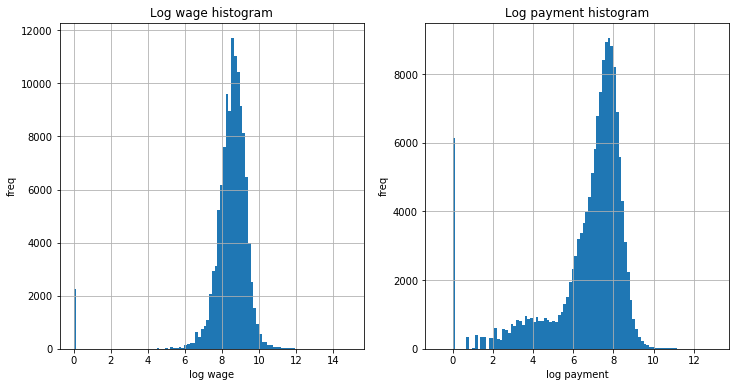

In [52]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
plt.subplot(1,2,1)
df['logMI'].hist(bins=100)
plt.ylabel('freq')
plt.xlabel('log wage')
plt.title('Log wage histogram')

plt.subplot(1,2,2)
df['logMP'].hist(bins=100)
plt.ylabel('freq')
plt.xlabel('log payment')
plt.title('Log payment histogram')


Ignoring the 0s, there is something very "normal" looing about log wages, which should not be shocking to anyone in a dataset of this size. Log payment is negatively skewed. In any case, the log transformations make these datum much more manageable.

In [53]:
train = df[df['logMI'].isnull() == False]
test = df[df['logMI'].isnull()]

In [54]:
X_train = train.drop(['MonthlyIncome','logMI','SeriousDlqin2yrs','MonthlyPayments','logMP'], axis=1)
y_train = train['logMI']
X_test = test.drop(['MonthlyIncome','logMI','SeriousDlqin2yrs','MonthlyPayments','logMP'], axis=1)

In [55]:
X_train.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,0.766127,45,2.0,0.802982,13,0.0,6.0,0.0,2.0
2,0.957151,40,0.0,0.121876,4,0.0,0.0,0.0,1.0
3,0.658180,38,1.0,0.085113,2,1.0,0.0,0.0,0.0
4,0.233810,30,0.0,0.036050,5,0.0,0.0,0.0,0.0
5,0.907239,49,1.0,0.024926,7,0.0,1.0,0.0,0.0


In [56]:
grad=GradientBoostingRegressor(learning_rate=0.05,n_estimators=350)

In [57]:
pred = cross_val_predict(grad,X_train,y_train,cv=10)

In [58]:
print(r2_score(y_train,pred))
print(mean_squared_error(y_train,pred))

0.830275598896
0.311223957583


Let's fill in the missing incomes.

In [59]:
grad.fit(X_train,y_train)
test_pred = grad.predict(X_test)

In [60]:
df.loc[df['logMI'].isnull(),'logMI'] = test_pred

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 14 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null float64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null float64
NumberRealEstateLoansOrLines            150000 non-null float64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null float64
NumberOfDependents                      150000 non-null float64
MonthlyPayments                         150000 non-null float64
logMI                                   150000 non-null float64
logMP                                   150000 non-null float64

In [206]:
df.to_csv('cs-trainmod.csv')

In [172]:
features = ['RevolvingUtilizationOfUnsecuredLines','age','NumberOfTime30-59DaysPastDueNotWorse',
           'NumberOfOpenCreditLinesAndLoans','NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines',
           'NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents','logMI','logMP']

<a id="visual"></a>
## t-SNE and PCA Visualization

Let's transform n dimensions into 2. t-SNE emphasizes placing similar features near each other, as opposed to methods like PCA which focus on maximizing variance/separating differences.

In [173]:
X = df[features]
y = df['SeriousDlqin2yrs']

sns.set(rc={'figure.figsize':(12,12)})

### t-SNE

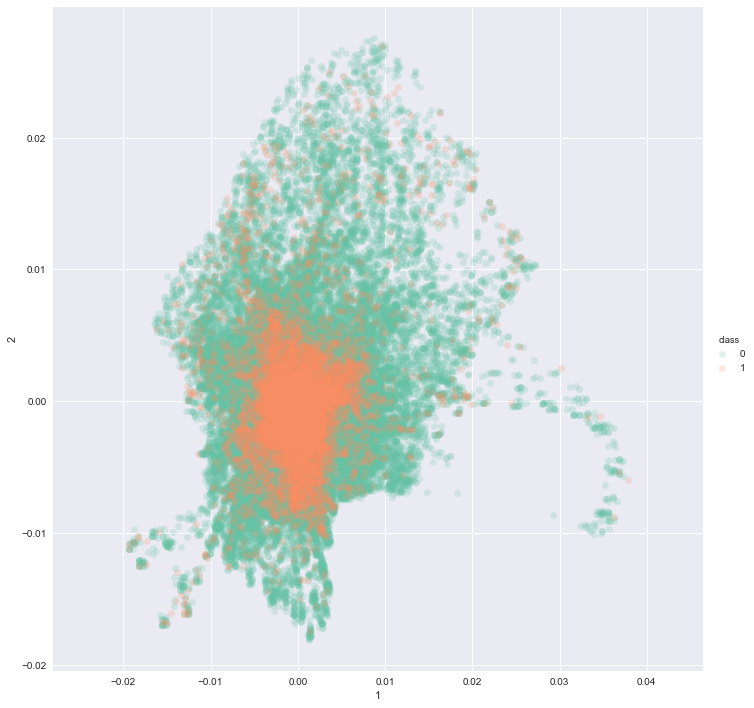

In [203]:
tsne = TSNE(early_exaggeration=4.0, learning_rate=25.0, n_iter=250)

# this stuff takes a long time, let's take a smaller sample

X_samp, X_notused, y_samp, y_notused = train_test_split(X, y, test_size=0.1)

transtsne = tsne.fit_transform(X_samp)

tsnedf = pd.DataFrame(transtsne, columns=['1', '2'])
y_samp.index = range(0,len(tsnedf))
tsnedf['class'] = y_samp

sns.lmplot(x='1', y='2', data = tsnedf,hue='class',size=10,palette="Set2",fit_reg=False,scatter_kws={'alpha':0.2})

### PCA

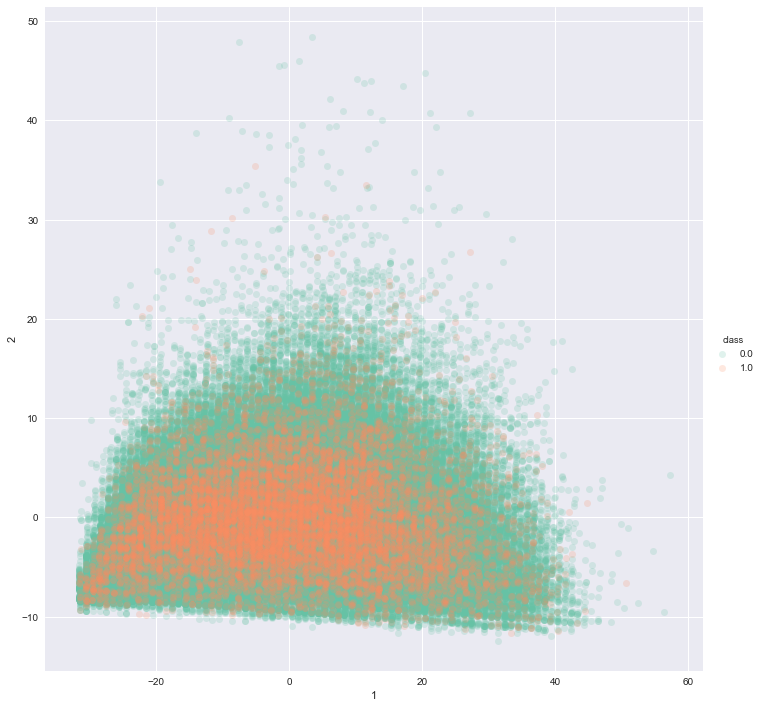

In [175]:
ss = StandardScaler()
X_norm = ss.fit_transform(X)
forPca = pd.DataFrame(X)

pct = PCA(n_components=2)
X_trans = pct.fit_transform(X)
pcadf = pd.DataFrame(X_trans,columns=['1','2'])
pcadf['class'] = y

sns.lmplot(x='1',y='2',data=pcadf,hue='class',size=10,fit_reg=False,palette="Set2",scatter_kws={'alpha':0.2})
#plt.axis([-500, 1500, -50, 50])

We can see that there are significant overlaps, but there are regions where there are clearly more class 0s than 1s. Particularly in the t-SNE graph, there is a major high risk concentration near the middle.

<a id="model"></a>
## Building the model

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Optimize the hyperparameters. Maybe watch a couple of movies.

In [177]:
grad_test = GradientBoostingRegressor(learning_rate=0.05,n_estimators=350)
hyper_params = {
                'n_estimators': randint(10, 650),
                'max_depth': randint(1,10),
                'min_samples_split': randint(2,5),
                'min_samples_leaf': randint(1,5)}

In [186]:
search = RandomizedSearchCV(grad_test, param_distributions=hyper_params, n_jobs=4, scoring='roc_auc', verbose=4, cv=5)
search.fit(X_train,y_train)
search.best_params_, search.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 14.6min finished


({'max_depth': 3,
  'min_samples_leaf': 3,
  'min_samples_split': 3,
  'n_estimators': 334},
 0.8629315910687488)

In [187]:
probs = search.best_estimator_.predict(X_test)

In [189]:
roc_auc_score(y_test,probs)

0.8651568232400102

This method scored 0.866752 on the Kaggle private set (70% of the test set), compared to the 0.869558 first place score.

The numbers seem close, but this disparity could mean several hundred more wrong lending decisions out of 150,000.

### Optimal Risk Threshold

Let's try to set an optimal risk threshold for a lender, since lending to someone with a slightly below 50% chance of default is probably not a great idea.

In [226]:
highest_auc = 0
opt_thresh = 0
n = 10000
for i in range(n):
    thresh = i/n
    dec = [1 if p > thresh else 0 for p in probs]
    auc = roc_auc_score(y_test,dec)
    if auc > highest_auc:
        highest_auc = auc
        opt_thresh = thresh
print (opt_thresh)
dec = [1 if p > opt_thresh else 0 for p in probs]

0.0645


Only lend when there is less than 6.45 % probability of default.

Compared to simply giving everyone a loan, we deny 1636 bad borrowers at the cost of denying 6338 good borrowers. With more data, it would be possible to go further and estimate the present values of these loans to predict a monetary value for a particular lending scheme. It is reasonable to assume that the average amount lost from a delinquincy greatly exceeds the discounted profit from a good loan.

Confusion matrix

[[21629  6338]
 [  397  1636]]

Normalized confusion matrix

[[ 0.77337576  0.22662424]
 [ 0.19527791  0.80472209]]

Classification report

             precision    recall  f1-score   support

          0       0.98      0.77      0.87     27967
          1       0.21      0.80      0.33      2033

avg / total       0.93      0.78      0.83     30000



Text(0.5,52,'Lender classification')

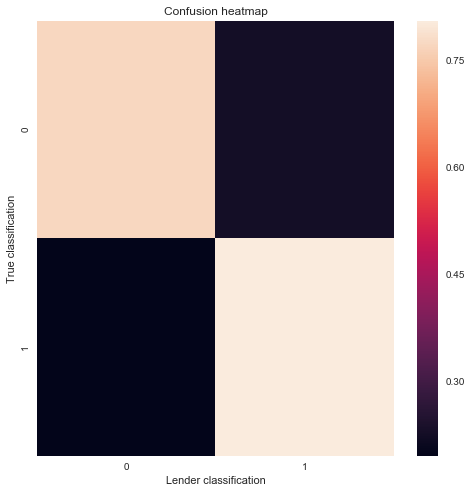

In [233]:
conf = confusion_matrix(y_test,dec)

norm_conf = conf.astype('float') / conf.sum(axis=1)[:,np.newaxis]

print ('Confusion matrix\n')
print (conf)
print ('\nNormalized confusion matrix\n')
print (norm_conf)
print ('\nClassification report\n')
print (classification_report(y_test,dec))

plt.figure(figsize=(8,8))
sns.heatmap(norm_conf)
plt.title('Confusion heatmap')
plt.ylabel('True classification')
plt.xlabel('Lender classification')

<a id="age"></a>
## How Useful is Age?

Age is useful in income prediction, but how good is it assessing risk in this data set? Should we try to create a model with binned ages or leave it as is for now?

### Weight of Evidence and Information Value

We can use a more traditional method such as weight of evidence (WoE) to assess age.

WoE: log(%non event/% event) where the "event" in question is delinquincy

Age is technically already binned, since time is a continuous variable and we're rounding down to whole numbers. Still, grouping them further may make it more useful. As we saw from the income analysis above, there is evidence that income groups can be usefully binned. However, we will stick with age for now.

Text(0.5,1,'Number of loans by age')

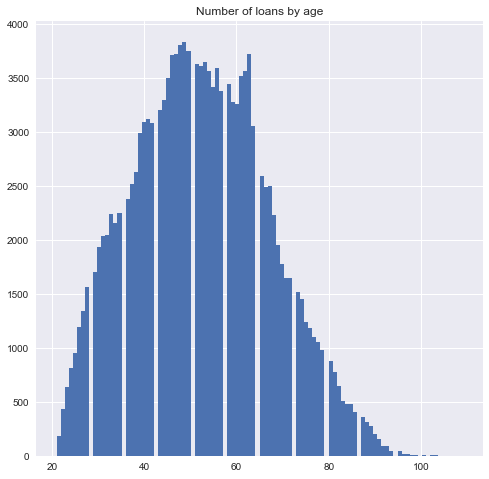

In [362]:
plt.figure(figsize=(8,8))
df['age'].hist(bins=100)
plt.title('Number of loans by age')

Preliminarily, let's be generous and say that everyone above 81 is now 81.

In [366]:
df2['age'] = [v if v <= 81 else 81 for v in df2['age']]

In [367]:
unique_ages = df2['age'].value_counts().index.sort_values()

In [369]:
bad_age = []
good_age = []
for a in unique_ages:
    good_age.append(df2[df2['age']==a].groupby('SeriousDlqin2yrs').count()['age'][0])
    bad_age.append(df2[df2['age']==a].groupby('SeriousDlqin2yrs').count()['age'][1])

In [370]:
age_df = pd.DataFrame(list(zip(unique_ages,good_age,bad_age)),columns=['Age','TotalNonDlq','TotalDlq'])
total_good = sum(age_df['TotalNonDlq'])
total_dlq = sum(age_df['TotalDlq'])

In [372]:
age_df['PercentNonDlq'] = age_df['TotalNonDlq'].apply(lambda v:v/total_good)
age_df['PercentDlq'] = age_df['TotalDlq'].apply(lambda v:v/total_dlq)

In [373]:
age_df['WoE'] = np.log(age_df['PercentNonDlq']/age_df['PercentDlq'])

Text(0.5,1,'WoE by Age')

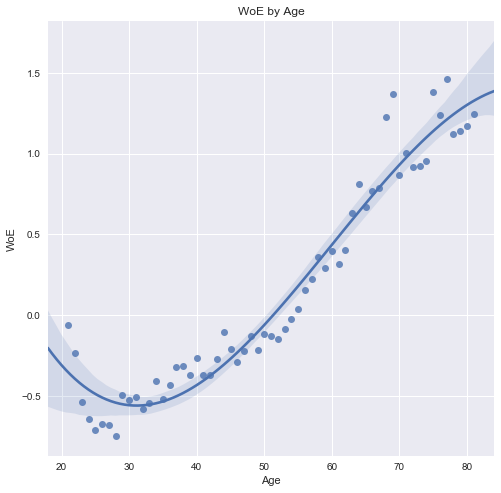

In [374]:
plt.figure(figsize=(8,8))
sns.regplot('Age','WoE',age_df,order=3)
plt.title ('WoE by Age')

The cubic fit line doesn't really have any use, it just looks nice.

We can also find the information value for each age.

In [375]:
age_df['IV'] = age_df['WoE']*(age_df['PercentNonDlq'] - age_df['PercentDlq'])
age_df.head()

,Age,TotalNonDlq,TotalDlq,PercentNonDlq,PercentDlq,WoE,IV
0,21,171,13,0.001222,0.001297,-0.059561,0.000004
1,22,398,36,0.002843,0.003591,-0.233342,0.000174
2,23,571,70,0.004079,0.006982,-0.537381,0.001560
3,24,718,98,0.005130,0.009775,-0.644773,0.002995
4,25,832,121,0.005944,0.012069,-0.708233,0.004338


Siddiqi (2006) suggests that a bin with an IV of under 0.1 has weak predictive power, and under 0.02 it's not useful at all.  We should aim for the (0.3,0.5) range.

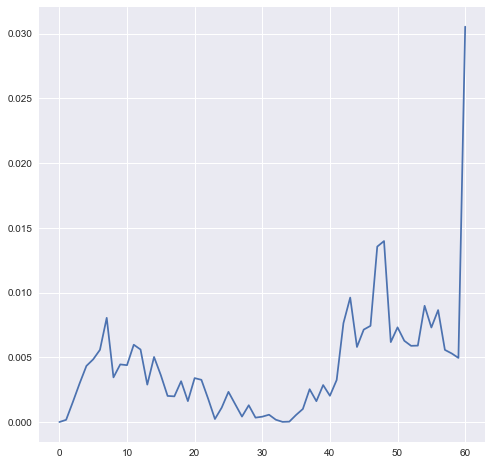

In [387]:
plt.figure(figsize=[8,8])
age_df['IV'].plot()

The IVs are very low, so let's try binning them further.

In [577]:
freq=pd.DataFrame(sorted(df2['age']))

In [558]:
df2['ageCat'] = np.digitize(np.array(df2['age']),freq.quantile(q=np.arange(0.1,0.9,0.1))[0].values)

In [559]:
unique_cats = df2['ageCat'].value_counts().index.sort_values()

In [560]:
bad_cat = []
good_cat = []
for a in unique_cats:
    good_cat.append(df2[df2['ageCat']==a].groupby('SeriousDlqin2yrs').count()['ageCat'][0])
    bad_cat.append(df2[df2['ageCat']==a].groupby('SeriousDlqin2yrs').count()['ageCat'][1])

In [561]:
cat_df = pd.DataFrame(list(zip(unique_cats,good_cat,bad_cat)),columns=['ageCat','TotalNonDlq','TotalDlq'])

In [562]:
cat_df['PercentNonDlq'] = cat_df['TotalNonDlq'].apply(lambda v:v/total_good)
cat_df['PercentDlq'] = cat_df['TotalDlq'].apply(lambda v:v/total_dlq)
cat_df['WoE'] = np.log(cat_df['PercentNonDlq']/cat_df['PercentDlq'])
cat_df['IV'] = cat_df['WoE']*(cat_df['PercentNonDlq'] - cat_df['PercentDlq'])

In [563]:
cat_df

,ageCat,TotalNonDlq,TotalDlq,PercentNonDlq,PercentDlq,WoE,IV
0,0,13152,1694,0.093960,0.168961,-0.586794,0.044010
1,1,12775,1396,0.091267,0.139238,-0.422396,0.020263
2,2,14089,1403,0.100654,0.139936,-0.329493,0.012943
3,3,13073,1156,0.093396,0.115300,-0.210692,0.004615
4,4,13872,1151,0.099104,0.114802,-0.147034,0.002308
5,5,13229,1005,0.094510,0.100239,-0.058851,0.000337
6,6,16074,871,0.114836,0.086874,0.279041,0.007802
7,7,13299,568,0.095011,0.056653,0.517048,0.019833
8,8,30411,782,0.217262,0.077997,1.024430,0.142667


It seems like age by itself is not worth binning, with such low IV scores. However, these only apply for age categories on their own. It is entirely possible that they can be the basis for features that may be useful. A few that come to mind include finding the log difference between an individual's income and their age group average, or a similar measure of dependents relative to the group average.

Measures such as these may give additional information about an individual's ability to pay, and they would be useful to explore in any further research.

<a id="conc"></a>
## Conclusion

Without using XGBoost or more advanced ensemble methods, we managed to achieve a score of 0.866752 on the Kaggle private leaderboard. The log transformations removed many of the outliers, but it's not clear how much of a difference this made in our final model, since decision tree methods tend to be robust for monotonic transformations.

In addition to the features mentioned above for age we could try traditional methods like including squared features or trying different interactions and ratios between the existing features. We could also try to improve monthly income estimation, which is in itself a large topic. Finding more uses for age could be a major component of that.